In [1]:
import dateutil
import datetime
import numpy as np
import pandas as pd

In [2]:
fips = pd.read_csv('../Data/all-geocodes-v2016.csv')
fips.columns=['summary', 'state', 'county', 'sub', 'place', 'city', 'name']
fips = fips[fips.summary == 50]
fips['code'] = fips.state*1000 + fips.county
vafips = fips[fips.state == 51]
vafips = vafips[['name', 'code']]
nyfips = fips[fips.state == 36]
nyfips = nyfips[['name', 'code']]

In [3]:
listing = pd.read_csv('../Data/County_MedianListingPrice_AllHomes.csv',encoding='latin1')
listing = pd.melt(listing, id_vars=['StateCodeFIPS','MunicipalCodeFIPS'], value_vars=['2010-01', '2010-02', '2010-03',
       '2010-04', '2010-05', '2010-06', '2010-07', '2010-08', '2010-09',
       '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03',
       '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09',
       '2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03',
       '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09',
       '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03',
       '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09',
       '2013-10', '2013-11', '2013-12', '2014-01', '2014-02', '2014-03',
       '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09',
       '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03',
       '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09',
       '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03',
       '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09',
       '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03',
       '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09',
       '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03',
       '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09',
       '2018-10'], var_name = 'date', value_name = 'price')
listing['FIPS'] = 1000*listing.StateCodeFIPS + listing.MunicipalCodeFIPS
listing = listing[['FIPS', 'date', 'price']]
fipsmin = listing['FIPS']>51000
fipsmax = listing['FIPS']<52000
listingva = listing[fipsmin & fipsmax]
listingva.date = listingva.date.apply(dateutil.parser.parse)
listingva.date = pd.to_datetime(listingva.date).map(lambda dt: dt.replace(day=1))
listingva = listingva.sort_values(by=['FIPS', 'date'])
listingva['prev_price_change'] = listingva.groupby(by=['FIPS'])['price'].pct_change(periods=12)*100
listingva1 = listingva[['FIPS', 'date', 'prev_price_change']]
listingva1.date = listingva1.date.apply(lambda x: x - pd.DateOffset(months=12))
listingva1.columns = ['FIPS', 'date', 'future_price_change']
listingva = pd.merge(listingva, listingva1, on=['FIPS', 'date'])
listingva.dropna()
fipsmin = listing['FIPS']>36000
fipsmax = listing['FIPS']<37000
listingny = listing[fipsmin & fipsmax]
listingny.date = listingny.date.apply(dateutil.parser.parse)
listingny.date = pd.to_datetime(listingny.date).map(lambda dt: dt.replace(day=1))
listingny = listingny.sort_values(by=['FIPS', 'date'])
listingny['prev_price_change'] = listingny.groupby(by=['FIPS'])['price'].pct_change(periods=12)*100
listingny1 = listingny[['FIPS', 'date', 'prev_price_change']]
listingny1.date = listingny1.date.apply(lambda x: x - pd.DateOffset(months=12))
listingny1.columns = ['FIPS', 'date', 'future_price_change']
listingny = pd.merge(listingny, listingny1, on=['FIPS', 'date'])
listingny.dropna()
listingny = listingny[listingny.date > '2013-12-31']
listing = pd.concat([listingva, listingny])

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [78]:
unemployment = pd.read_csv('../Data/Unemployment Data.csv')
unemployment.series_id = unemployment.series_id.str[5:]
unemployment.series_id = unemployment.series_id.str[:5]
unemployment = unemployment.drop('footnote_codes', axis=1)
unemployment = unemployment[unemployment.period != 'M13']
unemployment.period = unemployment.period.str[1:]
unemployment['date'] = unemployment['year'].astype(str) + '-' + unemployment['period']
unemployment = unemployment.sort_values(by=['series_id', 'date']).reset_index()
unemployment.date = unemployment.date.apply(dateutil.parser.parse)
unemployment.date = unemployment.date.map(lambda dt: dt.replace(day=1))
unemployment['annual_unemp_change'] = unemployment.groupby(by=['series_id'])['value'].diff(periods=12)
unemployment = unemployment.rename({'value': 'unemp_rate'}, axis=1)
unemployment = unemployment[['series_id', 'date', 'unemp_rate', 'annual_unemp_change']]
unemployment.series_id = unemployment.series_id.astype(int)
unemployment = unemployment.dropna()

In [5]:
foreclosure = pd.read_csv('../Data/ForeclosuresPer10Khomes_County.csv')
foreclosure = pd.melt(foreclosure, id_vars=['RegionID'], value_vars=['2008-01',
       '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07',
       '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2009-01',
       '2009-02', '2009-03', '2009-04', '2009-05', '2009-06', '2009-07',
       '2009-08', '2009-09', '2009-10', '2009-11', '2009-12', '2010-01',
       '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07',
       '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01',
       '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07',
       '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01',
       '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07',
       '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', '2013-01',
       '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07',
       '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01',
       '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07',
       '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01',
       '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07',
       '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01',
       '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07',
       '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01',
       '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07',
       '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01',
       '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10'])
crosswalk = pd.read_csv('../Data/CountyCrossWalk_Zillow.csv')
cross = crosswalk[['CountyRegionID_Zillow', 'FIPS']]
foreclosure = pd.merge(foreclosure, crosswalk, left_on='RegionID', right_on='CountyRegionID_Zillow')
foreclosure = foreclosure[['FIPS', 'variable', 'value']]
foreclosure.columns = ['FIPS', 'date', 'foreclose_rate']
foreclosure = foreclosure.dropna()
foreclosure.date = foreclosure.date.apply(dateutil.parser.parse)
foreclosure.date = pd.to_datetime(foreclosure.date).map(lambda dt: dt.replace(day=1))
foreclosure = foreclosure.sort_values(by=['FIPS', 'date'])
foreclosure['foreclose_rate_change'] = foreclosure.foreclose_rate.rolling(window=12).mean()
foreclosure = foreclosure.dropna()

In [6]:
population = pd.read_csv('../Data/PEP_2017_PEPANNRES_with_ann.csv', encoding='latin1')
population.drop(population.index[0],inplace=True)
population = population[['GEO.id2', 'respop72010', 'respop72011', 'respop72012', 'respop72013', 'respop72014',
                         'respop72015', 'respop72016', 'respop72017']]
population.columns = ['FIPS', '2010-07', '2011-07', '2012-07', '2013-07', '2014-07', '2015-07', '2016-07', '2017-07']
population['2010-08'] = population['2010-07']
population['2010-09'] = population['2010-07']
population['2010-10'] = population['2010-07']
population['2010-11'] = population['2010-07']
population['2010-12'] = population['2010-07']
population['2011-01'] = population['2010-07']
population['2011-02'] = population['2010-07']
population['2011-03'] = population['2010-07']
population['2011-04'] = population['2010-07']
population['2011-05'] = population['2010-07']
population['2011-06'] = population['2010-07']
population['2011-08'] = population['2011-07']
population['2011-09'] = population['2011-07']
population['2011-10'] = population['2011-07']
population['2011-11'] = population['2011-07']
population['2011-12'] = population['2011-07']
population['2012-01'] = population['2011-07']
population['2012-02'] = population['2011-07']
population['2012-03'] = population['2011-07']
population['2012-04'] = population['2011-07']
population['2012-05'] = population['2011-07']
population['2012-06'] = population['2011-07']
population['2012-08'] = population['2012-07']
population['2012-09'] = population['2012-07']
population['2012-10'] = population['2012-07']
population['2012-11'] = population['2012-07']
population['2012-12'] = population['2012-07']
population['2013-01'] = population['2012-07']
population['2013-02'] = population['2012-07']
population['2013-03'] = population['2012-07']
population['2013-04'] = population['2012-07']
population['2013-05'] = population['2012-07']
population['2013-06'] = population['2012-07']
population['2013-08'] = population['2013-07']
population['2013-09'] = population['2013-07']
population['2013-10'] = population['2013-07']
population['2013-11'] = population['2013-07']
population['2013-12'] = population['2013-07']
population['2014-01'] = population['2013-07']
population['2014-02'] = population['2013-07']
population['2014-03'] = population['2013-07']
population['2014-04'] = population['2013-07']
population['2014-05'] = population['2013-07']
population['2014-06'] = population['2013-07']
population['2014-08'] = population['2014-07']
population['2014-09'] = population['2014-07']
population['2014-10'] = population['2014-07']
population['2014-11'] = population['2014-07']
population['2014-12'] = population['2014-07']
population['2015-01'] = population['2014-07']
population['2015-02'] = population['2014-07']
population['2015-03'] = population['2014-07']
population['2015-04'] = population['2014-07']
population['2015-05'] = population['2014-07']
population['2015-06'] = population['2014-07']
population['2015-08'] = population['2015-07']
population['2015-09'] = population['2015-07']
population['2015-10'] = population['2015-07']
population['2015-11'] = population['2015-07']
population['2015-12'] = population['2015-07']
population['2016-01'] = population['2015-07']
population['2016-02'] = population['2015-07']
population['2016-03'] = population['2015-07']
population['2016-04'] = population['2015-07']
population['2016-05'] = population['2015-07']
population['2016-06'] = population['2015-07']
population['2016-08'] = population['2016-07']
population['2016-09'] = population['2016-07']
population['2016-10'] = population['2016-07']
population['2016-11'] = population['2016-07']
population['2016-12'] = population['2016-07']
population['2017-01'] = population['2016-07']
population['2017-02'] = population['2016-07']
population['2017-03'] = population['2016-07']
population['2017-04'] = population['2016-07']
population['2017-05'] = population['2016-07']
population['2017-06'] = population['2016-07']
population['2017-08'] = population['2017-07']
population['2017-09'] = population['2017-07']
population['2017-10'] = population['2017-07']
population['2017-11'] = population['2017-07']
population['2017-12'] = population['2017-07']
population['2018-01'] = population['2017-07']
population['2018-02'] = population['2017-07']
population['2018-03'] = population['2017-07']
population['2018-04'] = population['2017-07']
population['2018-05'] = population['2017-07']
population['2018-06'] = population['2017-07']
population = pd.melt(population, id_vars = ['FIPS'], value_vars=['2010-07', '2011-07', '2012-07', '2013-07', '2014-07',
       '2015-07', '2016-07', '2017-07', '2010-08', '2010-09', '2010-10',
       '2010-11', '2010-12', '2011-01', '2011-02', '2011-03', '2011-04',
       '2011-05', '2011-06', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05',
       '2012-06', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01',
       '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-08', '2015-09',
       '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03',
       '2016-04', '2016-05', '2016-06', '2016-08', '2016-09', '2016-10',
       '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
       '2017-05', '2017-06', '2017-08', '2017-09', '2017-10', '2017-11',
       '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05',
       '2018-06'])
population.columns = ['FIPS', 'date', 'popul']
population.date = population.date.apply(dateutil.parser.parse)
population.date = pd.to_datetime(population.date).map(lambda dt: dt.replace(day=1))
population.popul = population.popul.astype(int)
population = population.sort_values(by=['FIPS', 'date']).reset_index()
population['annual_popul_change'] = population.groupby(by=['FIPS'])['popul'].pct_change(periods=12)
population = population[['FIPS', 'date', 'popul', 'annual_popul_change']]
population.FIPS = population.FIPS.astype(int)

In [7]:
inventory = pd.read_csv('../Data/InventoryMeasure_County_Public.csv', encoding='latin1')
inventory = pd.melt(inventory, id_vars=['CountyName', 'StateFullName'], 
                    value_vars=['2010-01', '2010-02', '2010-03', '2010-04',
       '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10',
       '2010-11', '2010-12', '2011-01', '2011-02', '2011-03', '2011-04',
       '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10',
       '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04',
       '2012-05', '2012-06', '2012-07', '2012-08', '2012-09', '2012-10',
       '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04',
       '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10',
       '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04',
       '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10',
       '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04',
       '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10',
       '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04',
       '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10',
       '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
       '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10',
       '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04',
       '2018-05', '2018-06', '2018-07', '2018-08', '2018-09'], var_name = 'month', value_name = 'inven')
cross2 = crosswalk[['CountyName', 'StateName', 'FIPS']]
inventory = pd.merge(inventory, cross2, left_on = ['CountyName', 'StateFullName'], right_on = ['CountyName', 'StateName'])
inventory = inventory[['FIPS', 'month', 'inven']]
inventory = inventory.sort_values(by=['FIPS', 'month'])
inventory.month = inventory.month.apply(dateutil.parser.parse)
inventory.month = pd.to_datetime(inventory.month).map(lambda dt: dt.replace(day=1))
inventory['inven_change'] = inventory.groupby(by=['FIPS'])['inven'].pct_change(periods=12)

In [16]:
income = pd.read_csv('../Data/personal_income.csv', encoding='latin1')
income.GeoFIPS = income.GeoFIPS.str.strip()
income.GeoFIPS = income.GeoFIPS.str[1:6]
income.GeoFIPS = income.GeoFIPS.astype(int)
income.columns = ['FIPS', 'GeoName', 'Region', 'TableName', 'LineCode',
       'IndustryClassification', 'Description', 'Unit', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010-07',
       '2011-07', '2012-07', '2013-07', '2014-07', '2015-07', '2016-07', '2017-07']
income['2010-08'] = income['2010-07']
income['2010-09'] = income['2010-07']
income['2010-10'] = income['2010-07']
income['2010-11'] = income['2010-07']
income['2010-12'] = income['2010-07']
income['2011-01'] = income['2010-07']
income['2011-02'] = income['2010-07']
income['2011-03'] = income['2010-07']
income['2011-04'] = income['2010-07']
income['2011-05'] = income['2010-07']
income['2011-06'] = income['2010-07']
income['2011-08'] = income['2011-07']
income['2011-09'] = income['2011-07']
income['2011-10'] = income['2011-07']
income['2011-11'] = income['2011-07']
income['2011-12'] = income['2011-07']
income['2012-01'] = income['2011-07']
income['2012-02'] = income['2011-07']
income['2012-03'] = income['2011-07']
income['2012-04'] = income['2011-07']
income['2012-05'] = income['2011-07']
income['2012-06'] = income['2011-07']
income['2012-08'] = income['2012-07']
income['2012-09'] = income['2012-07']
income['2012-10'] = income['2012-07']
income['2012-11'] = income['2012-07']
income['2012-12'] = income['2012-07']
income['2013-01'] = income['2012-07']
income['2013-02'] = income['2012-07']
income['2013-03'] = income['2012-07']
income['2013-04'] = income['2012-07']
income['2013-05'] = income['2012-07']
income['2013-06'] = income['2012-07']
income['2013-08'] = income['2013-07']
income['2013-09'] = income['2013-07']
income['2013-10'] = income['2013-07']
income['2013-11'] = income['2013-07']
income['2013-12'] = income['2013-07']
income['2014-01'] = income['2013-07']
income['2014-02'] = income['2013-07']
income['2014-03'] = income['2013-07']
income['2014-04'] = income['2013-07']
income['2014-05'] = income['2013-07']
income['2014-06'] = income['2013-07']
income['2014-08'] = income['2014-07']
income['2014-09'] = income['2014-07']
income['2014-10'] = income['2014-07']
income['2014-11'] = income['2014-07']
income['2014-12'] = income['2014-07']
income['2015-01'] = income['2014-07']
income['2015-02'] = income['2014-07']
income['2015-03'] = income['2014-07']
income['2015-04'] = income['2014-07']
income['2015-05'] = income['2014-07']
income['2015-06'] = income['2014-07']
income['2015-08'] = income['2015-07']
income['2015-09'] = income['2015-07']
income['2015-10'] = income['2015-07']
income['2015-11'] = income['2015-07']
income['2015-12'] = income['2015-07']
income['2016-01'] = income['2015-07']
income['2016-02'] = income['2015-07']
income['2016-03'] = income['2015-07']
income['2016-04'] = income['2015-07']
income['2016-05'] = income['2015-07']
income['2016-06'] = income['2015-07']
income['2016-08'] = income['2016-07']
income['2016-09'] = income['2016-07']
income['2016-10'] = income['2016-07']
income['2016-11'] = income['2016-07']
income['2016-12'] = income['2016-07']
income['2017-01'] = income['2016-07']
income['2017-02'] = income['2016-07']
income['2017-03'] = income['2016-07']
income['2017-04'] = income['2016-07']
income['2017-05'] = income['2016-07']
income['2017-06'] = income['2016-07']
income['2017-08'] = income['2017-07']
income['2017-09'] = income['2017-07']
income['2017-10'] = income['2017-07']
income['2017-11'] = income['2017-07']
income['2017-12'] = income['2017-07']
income['2018-01'] = income['2017-07']
income['2018-02'] = income['2017-07']
income['2018-03'] = income['2017-07']
income['2018-04'] = income['2017-07']
income['2018-05'] = income['2017-07']
income['2018-06'] = income['2017-07']
income_pc = income[income.LineCode == 30]
income_pc = pd.melt(income_pc, id_vars = ['FIPS'], value_vars=['2010-07', '2011-07', '2012-07', '2013-07', '2014-07',
       '2015-07', '2016-07', '2017-07', '2010-08', '2010-09', '2010-10',
       '2010-11', '2010-12', '2011-01', '2011-02', '2011-03', '2011-04',
       '2011-05', '2011-06', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05',
       '2012-06', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01',
       '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-08', '2015-09',
       '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03',
       '2016-04', '2016-05', '2016-06', '2016-08', '2016-09', '2016-10',
       '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
       '2017-05', '2017-06', '2017-08', '2017-09', '2017-10', '2017-11',
       '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05',
       '2018-06'], var_name = 'date', value_name = 'inc_pc')
income_pc = income_pc.sort_values(by=['FIPS', 'date'])
income_pc.date = income_pc.date.apply(dateutil.parser.parse)
income_pc.date = pd.to_datetime(income_pc.date).map(lambda dt: dt.replace(day=1))
income_pc = income_pc[income_pc.inc_pc != '(NA)']
income_pc.inc_pc = income_pc.inc_pc.astype(int)
income_pc['inc_pc_change'] = income_pc.groupby(by=['FIPS'])['inc_pc'].pct_change(periods=12)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
total_employment = income[income.LineCode == 7020]
total_employment = pd.melt(total_employment, id_vars = ['FIPS'], 
      value_vars=['2010-07', '2011-07', '2012-07', '2013-07', '2014-07',
       '2015-07', '2016-07', '2017-07', '2010-08', '2010-09', '2010-10',
       '2010-11', '2010-12', '2011-01', '2011-02', '2011-03', '2011-04',
       '2011-05', '2011-06', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05',
       '2012-06', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01',
       '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-08', '2015-09',
       '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03',
       '2016-04', '2016-05', '2016-06', '2016-08', '2016-09', '2016-10',
       '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
       '2017-05', '2017-06', '2017-08', '2017-09', '2017-10', '2017-11',
       '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05',
       '2018-06'], var_name = 'date', value_name = 'total_emp')
total_employment = total_employment.sort_values(by=['FIPS', 'date'])
total_employment.date = total_employment.date.apply(dateutil.parser.parse)
total_employment.date = pd.to_datetime(total_employment.date).map(lambda dt: dt.replace(day=1))
total_employment = total_employment[total_employment.total_emp != '(NA)']
total_employment.total_emp = total_employment.total_emp.astype(int)
total_employment['emp_change'] = total_employment.groupby(by=['FIPS'])['total_emp'].pct_change(periods=12)

In [50]:
inflation = pd.read_csv('../Data/Inflation.csv')
inflation = pd.melt(inflation, id_vars=['Year'],
                    value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                    var_name = 'month', value_name = 'price_index')
inflation = inflation.dropna()
inflation.Year = inflation.Year.astype(str)
inflation['timestamp'] = inflation.Year + '-' + inflation.month
inflation.timestamp = inflation.timestamp.apply(pd.to_datetime)
inf1 = inflation[['timestamp', 'price_index']]
inf1 = inf1.sort_values(by='timestamp')
inf1['inf_diff'] = inf1.price_index.diff(periods=12)
inf1.timestamp = inf1.timestamp.apply(lambda x: x - pd.DateOffset(months=12))
inf1 = inf1[['timestamp', 'inf_diff']]
inflation = pd.merge(inflation, inf1, on=['timestamp'])
inflation.inf_diff = inflation.inf_diff/inflation.price_index
inflation = inflation[['timestamp', 'inf_diff']]

In [11]:
va_jobs_added = pd.read_csv('../Data/AnnouncementsData.csv')
va_jobs_added.drop(va_jobs_added.index[2688:],inplace=True)
va_jobs_added.columns = ['company', 'county', 'NAICS', 'descript', 'date', 'new_expand', 'jobs_added', 'investment']
va_jobs_added.jobs_added = va_jobs_added.jobs_added.astype(int)
va_jobs_added.NAICS = va_jobs_added.NAICS.astype(int)
va_jobs_added.date = va_jobs_added.date.apply(dateutil.parser.parse)
va_jobs_added['month'] = pd.to_datetime(va_jobs_added['date']).map(lambda dt: dt.replace(day=1))
va_jobs_added['agriculture_added'] = np.where(va_jobs_added.NAICS < 100000, va_jobs_added.jobs_added, 0)
va_jobs_added['manufacturing_added'] = np.where((va_jobs_added.NAICS >= 100000) & (va_jobs_added.NAICS < 400000),\
                                                va_jobs_added.jobs_added, 0)
va_jobs_added['service_added'] = np.where(va_jobs_added.NAICS >= 400000, va_jobs_added.jobs_added, 0)
va_jobs_added['new'] = np.where(va_jobs_added.new_expand == 'N', va_jobs_added.jobs_added, 0)
va_jobs_added['expansion'] = np.where(va_jobs_added.new_expand == 'E', va_jobs_added.jobs_added, 0)
va_jobs_added.NAICS = va_jobs_added.NAICS.astype(str)
va_jobs_added1 = va_jobs_added.groupby(by=['month', 'county']).sum().reset_index()
va_jobs_lost = pd.read_csv('../Data/ClosingData.csv')
va_jobs_lost.drop(va_jobs_lost.index[399:],inplace=True)
va_jobs_lost.columns = ['company', 'county', 'NAICS', 'descript', 'jobs_lost', 'close_layoff', 'date', 'month_close']
va_jobs_lost.jobs_lost = va_jobs_lost.jobs_lost.astype(int)
va_jobs_lost.NAICS = va_jobs_lost.NAICS.astype(int)
va_jobs_lost.date = va_jobs_lost.date.apply(dateutil.parser.parse)
va_jobs_lost['month'] = pd.to_datetime(va_jobs_lost['date']).map(lambda dt: dt.replace(day=1))
va_jobs_lost['agriculture_closed'] = np.where(va_jobs_lost.NAICS < 100000, va_jobs_lost.jobs_lost, 0)
va_jobs_lost['manufacturing_closed'] = np.where((va_jobs_lost.NAICS >= 100000) & (va_jobs_lost.NAICS < 400000),\
                                                va_jobs_lost.jobs_lost, 0)
va_jobs_lost['service_closed'] = np.where(va_jobs_lost.NAICS >= 400000, va_jobs_lost.jobs_lost, 0)
va_jobs_lost['layoff'] = np.where(va_jobs_lost.close_layoff == 'Layoff', va_jobs_lost.jobs_lost, 0)
va_jobs_lost['closing'] = np.where(va_jobs_lost.close_layoff == 'Closing', va_jobs_lost.jobs_lost, 0)
va_jobs_lost.NAICS = va_jobs_lost.NAICS.astype(str)
va_jobs_lost1 = va_jobs_lost.groupby(by=['month', 'county']).sum().reset_index()
va_jobs = pd.merge(va_jobs_added1, va_jobs_lost1, how='outer', on=['month', 'county'])
va_jobs = va_jobs.sort_values(by=['month', 'county'])
va_jobs.jobs_added = va_jobs.jobs_added.fillna(0)
va_jobs.jobs_lost = va_jobs.jobs_lost.fillna(0)
va_jobs.agriculture_added = va_jobs.agriculture_added.fillna(0)
va_jobs.agriculture_closed = va_jobs.agriculture_closed.fillna(0)
va_jobs.manufacturing_added = va_jobs.manufacturing_added.fillna(0)
va_jobs.manufacturing_closed = va_jobs.manufacturing_closed.fillna(0)
va_jobs.service_added = va_jobs.service_added.fillna(0)
va_jobs.service_closed = va_jobs.service_closed.fillna(0)
va_jobs.new = va_jobs.new.fillna(0)
va_jobs.expansion = va_jobs.expansion.fillna(0)
va_jobs.layoff = va_jobs.layoff.fillna(0)
va_jobs.closing = va_jobs.closing.fillna(0)

In [12]:
ny_jobs = pd.read_csv('../Data/Corporate Expansions NY.csv')
ny_jobs.new.fillna(0)
ny_jobs.expansion.fillna(0)
ny_jobs['month'] = pd.to_datetime(ny_jobs['date']).map(lambda dt: dt.replace(day=1))
ny_jobs.new = np.where(ny_jobs.new == 1, ny_jobs.jobs, 0)
ny_jobs.expansion = np.where(ny_jobs.expansion == 1, ny_jobs.jobs, 0)
ny_jobs = ny_jobs.groupby(by=['date', 'county']).sum().reset_index()
ny_jobs.columns = ['month', 'county', 'jobs_added', 'new', 'expansion']

In [79]:
va = pd.merge(va_jobs, vafips, left_on='county', right_on='name')
va = va[['month', 'code', 'jobs_added', 'new', 'expansion']]
ny = pd.merge(ny_jobs, nyfips, left_on='county', right_on='name')
ny = ny[['month', 'code', 'jobs_added', 'new', 'expansion']]
df = pd.concat([va, ny])
df = pd.merge(df, listing, how='right', left_on = ['code', 'month'], right_on = ['FIPS', 'date'])
df = df[['FIPS', 'date', 'price', 'prev_price_change', 'future_price_change', 'jobs_added', 'new', 'expansion']]
df.jobs_added = df.jobs_added.fillna(0)
df.new = df.new.fillna(0)
df.expansion = df.expansion.fillna(0)
df2 = df[['FIPS', 'date', 'jobs_added', 'new', 'expansion']]
df2['annual_jobs_added'] = df2.jobs_added.rolling(window=12).mean()
df2['quarterly_jobs_added'] = df2.jobs_added.rolling(window=3).sum()
df2['annual_new'] = df2.new.rolling(window=12).mean()
df2['quarterly_new'] = df2.new.rolling(window=3).sum()
df2['annual_expansion'] = df2.expansion.rolling(window=12).mean()
df2['quarterly_expansion'] = df2.expansion.rolling(window=3).sum()
df2 = df2[['FIPS', 'date', 'annual_jobs_added', 'annual_new', 'annual_expansion', 'quarterly_jobs_added', 'quarterly_new',
           'quarterly_expansion']]
df = pd.merge(df, df2, on=['FIPS', 'date'])
df = df.dropna()
df = pd.merge(df, unemployment, left_on = ['FIPS', 'date'], right_on = ['series_id', 'date'])
df = df.drop('series_id', axis=1)
df = pd.merge(df, population, left_on = ['date', 'FIPS'], right_on = ['date', 'FIPS'])
df = pd.merge(df, foreclosure, left_on = ['date', 'FIPS'], right_on = ['date', 'FIPS'])
df = pd.merge(df, inventory, left_on = ['FIPS', 'date'], right_on = ['FIPS', 'month'])
df['inven_popul'] = df.popul/df.inven
df = pd.merge(df, income_pc, left_on = ['FIPS', 'date'], right_on = ['FIPS', 'date'])
df = pd.merge(df, total_employment, left_on = ['FIPS', 'date'], right_on = ['FIPS', 'date'])
df = pd.merge(df, inflation, left_on = 'date', right_on = 'timestamp')
df = df.dropna()
df['emp_popul'] = df.total_emp/df.popul

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [18]:
y = df.future_price_change
X = df[['new', 'expansion', 'annual_new', 'annual_expansion', 'unemp_rate', 'annual_unemp_change',
        'annual_popul_change', 'foreclose_rate', 'inven', 'inven_change', 'inven_popul', 'emp_change',
        'inc_pc_change', 'inc_pc', 'inf_diff', 'prev_price_change', 'price', 'emp_popul']]

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
dfa = df[(df.jobs_added != 0)|(df.annual_jobs_added != 0)]
dfa.future_price_change.mean()
ya = dfa.future_price_change
Xa = dfa[['new', 'expansion', 'annual_new', 'annual_expansion', 'unemp_rate', 'annual_unemp_change',
          'annual_popul_change', 'foreclose_rate', 'inven', 'inven_change', 'inven_popul',
          'emp_change', 'inc_pc_change', 'inc_pc', 'inf_diff', 'prev_price_change', 'emp_popul', 'total_emp']]

In [23]:
dfb = df[(df.jobs_added == 0)&(df.annual_jobs_added == 0)]
dfb.future_price_change.mean()
yb = dfb.future_price_change
Xb = dfb[['new', 'expansion', 'annual_new', 'annual_expansion', 'unemp_rate', 'annual_unemp_change',
          'annual_popul_change', 'foreclose_rate', 'foreclose_rate_change', 'inven_change', 'inven_popul',
          'emp_change', 'inc_pc_change', 'inc_pc', 'inf_diff', 'prev_price_change', 'emp_popul', 'total_emp']]

In [55]:
from sklearn.ensemble import RandomForestRegressor
rfrt = RandomForestRegressor(n_estimators=500, n_jobs=-1).fit(X_train, y_train)
y_test_pred_rf = rfrt.predict(X_test)
y_train_pred_rf = rfrt.predict(X_train)
rfrt.score(X_test, y_test)

0.6794937997538506

In [56]:
rfrt_feature_importances = pd.DataFrame(rfrt.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
rfrt_feature_importances.sort_values

<bound method DataFrame.sort_values of                      importance
prev_price_change      0.111229
emp_change             0.110413
inven_change           0.093851
inven_popul            0.091878
price                  0.088849
inc_pc                 0.088070
inven                  0.066804
emp_popul              0.057598
unemp_rate             0.055578
inc_pc_change          0.053421
inf_diff               0.049150
annual_popul_change    0.047838
annual_unemp_change    0.038812
foreclose_rate         0.029705
annual_expansion       0.008140
annual_new             0.003955
expansion              0.002852
new                    0.001858>

In [57]:
from treeinterpreter import treeinterpreter as ti
prediction, bias, contributions = ti.predict(rfrt, Xa)

In [80]:
li = []
l = 0
v = 0
h = 0
x = 0
p = 0
for i in range(len(Xa)):
    #print("Instance", i)
    #print("Prediction", prediction[i])
    #print("Bias (trainset mean)", bias[i])
    #print("Feature contributions:")
    for c, feature in zip(contributions[i], 
                                 X.columns):
        #print(feature, round(c, 2))
        if feature == 'new':
            l += c
            x += c
        if feature == 'expansion':
            l += c
            x += c
        if feature == 'annual_new':
            l += c
            x += c
        if feature == 'annual_expansion':
            l += c
            x += c
        if feature == 'inven':
            v += c
        if feature == 'inven_popul':
            v += c/2
            h += c/2
        if feature == 'inven_change':
            v += c
        if feature == 'annual_popul_change':
            h += c
        if feature == 'prev_price_change':
            h += c
        if feature == 'price':
            h += c
    li.append(x)
    x = 0
    p += (prediction[i] - bias[i])
    #print("-"*20)

In [81]:
h/len(Xa)

1.1603851428266907

In [82]:
(p-l)/len(Xa)

1.618098389665181

In [83]:
sli = sorted(li)

In [62]:
sli[len(Xa)//20]

-0.2272168845206547

In [63]:
slif = sli[len(Xa)//20:len(Xa) - len(Xa)//20 + 1]

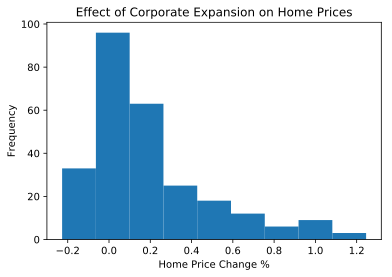

In [64]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.hist(slif, bins=9)
plt.title('Effect of Corporate Expansion on Home Prices')
plt.xlabel('Home Price Change %')
plt.ylabel('Frequency');

In [65]:
from sklearn import metrics
metrics.mean_squared_error(y_test, y_test_pred_rf) ** (1/2)

3.674447130960661

In [66]:
slif[-1]

1.2457925840922517

In [67]:
ar1 = [[0,0,39.25,93.6667,1.9,-0.4,0.001077,0.0,545,-0.0109477,450.409,0.236288,0.0254274,89487,0.013,14.6286,617000,\
        -6.373293]]
ar2 = [[25000,0,2005.5833,93.6667,1.9,-0.4,0.001077,0.0,545,-0.0109477,450.409,0.236288,0.0254274,89487,0.013,14.6286,\
        617000,-6.373293]]

In [68]:
ri1 = [[0,0,0,61,2.8,-0.6,0.005369,1.51,728,-0.181102,386.672,0.0214651,0.0428042,63634,0.013,9.00786,291000,0.692024]]
ri2 = [[25000,0,2083.3333,61,2.8,-0.6,0.005369,1.51,728,-0.181102,386.672,0.0214651,0.0428042,63634,0.013,9.00786,291000,\
        0.692024]]

In [69]:
qu1 = [[0,0,0,6.6667,3.4,-0.7,0.002179,1.28,4996,0.200962,472.09,0.0145054,0.0483639,63469,0.019,6.82192,59900,6.107699]]
qu2 = [[25000,0,2083.3333,6.6667,3.4,-0.7,0.002179,1.28,4996,0.200962,472.09,0.0145054,0.0483639,63469,0.019,6.82192,\
        59900,6.107699]]

In [70]:
test = [[ar1, ar2, ri1, ri2, qu1, qu2]]

In [71]:
dfa.future_price_change.mean()

5.078418583531138

In [72]:
dfb.future_price_change.mean()

3.2436156908041665

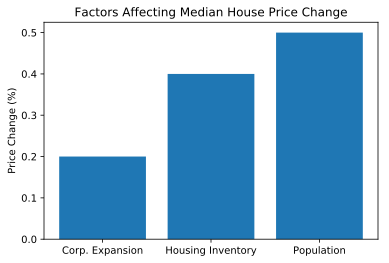

In [73]:
objects = ('Corp. Expansion', 'Housing Inventory', 'Population')
y_pos = np.arange(len(objects))
performance = [0.2,0.4,0.5]
 
plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Price Change (%)')
plt.title('Factors Affecting Median House Price Change');